```{margin} Adaptation!
This work was adapted from lecture notes in John Kitchin's excellent 06-623 course! His lecture notes are included in the helpful resources link if you want to know more details about how numerical methods work.
```

# Numerical ODE Integration (with Events!)


`````{note}
This lecture is going to:
* Quickly review how scipy.integrate.solve_ivp works
* Practice coding up a system of differential equations we covered extensively in 06-262
* Introduce how events works during ODE integrations (useful for future courses!)
* Demonstrate events for a more complicated non-linear higher order differential equation

Along the way, we will:
* Get used to the JupyterLab environment and the structure of the course notes
* Practice plotting in matplotlib
`````

## Review of scipy.integrate.solve_ivp

As an example, consider the first order ODE:
\begin{align*}
y' = y + 2x - x^2; y(0) = 1
\end{align*}

This ODE has a known analytical solution: $y(x) = x^2 + e^x$. We will use this for comparison.

The `scipy.integrate` library provides `solve_ivp` to solve first order differential equations. It is not the only one available, but this function is recommended. You import the function like this:

In [1]:
from scipy.integrate import solve_ivp
import numpy as np

Here is a minimal use of the function, with keyword arguments.

`y0` is an array containing the initial values.  `fun` is a function with a signature of f(t, y). Here, $t$ is considered the independent variable. You can call it whatever you want, so f(x, y) is also fine. Since `solve_ivp` had $t$ in mind, the second argument is the `t_span`, which is a tuple of two numbers for where the integration starts (t0, or x0) and where it ends.  `solve_ivp` returns an object.

In [2]:
def f(x, y):
    return y + 2 * x - x**2

x0 = 0
y0 = np.array([1]) # It is a good idea to make y0 an array. It will be important later.

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0)

The output of `solve_ip` is an object containing results in attributes on the object.

In [3]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.08034384, 0.86683456, 1.5       ])
 t_events: None
        y: array([[1.        , 1.09011474, 3.13086569, 6.73191444]])
 y_events: None

You should look for a few things here. One is that the message indicates success. Second, we access the solution using dot notation. Here are the independent variable values the solution was evaluated at.

In [4]:
sol.t

array([0.        , 0.08034384, 0.86683456, 1.5       ])

Third, the solution is in a 2D array. We only have one equation here, so we use indexing to get the first row as an array.

In [5]:
sol.y[0]

array([1.        , 1.09011474, 3.13086569, 6.73191444])

Now, we can plot the solution.

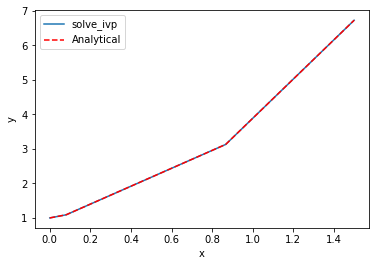

In [6]:
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.plot(sol.t, sol.t**2 + np.exp(sol.t), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

That doesn't looks so great since there are only four data points. By default, the algorithm only uses as many points as it needs to achieve a specified tolerance. We can specify that we want the solution evaluated at other points using the optional `t_eval` keyword arg.

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.03061224, 0.06122449, 0.09183673, 0.12244898,
       0.15306122, 0.18367347, 0.21428571, 0.24489796, 0.2755102 ,
       0.30612245, 0.33673469, 0.36734694, 0.39795918, 0.42857143,
       0.45918367, 0.48979592, 0.52040816, 0.55102041, 0.58163265,
       0.6122449 , 0.64285714, 0.67346939, 0.70408163, 0.73469388,
       0.76530612, 0.79591837, 0.82653061, 0.85714286, 0.8877551 ,
       0.91836735, 0.94897959, 0.97959184, 1.01020408, 1.04081633,
       1.07142857, 1.10204082, 1.13265306, 1.16326531, 1.19387755,
       1.2244898 , 1.25510204, 1.28571429, 1.31632653, 1.34693878,
       1.37755102, 1.40816327, 1.43877551, 1.46938776, 1.5       ])
 t_events: None
        y: array([[1.        , 1.03202273, 1.06688599, 1.10462029, 1.14526069,
        1.18883821, 1.23538386, 1.28493005, 1.33751066, 

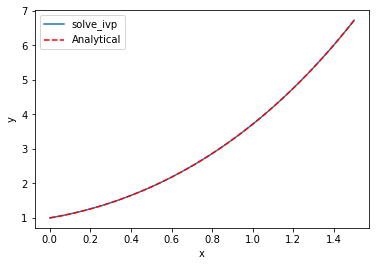

In [7]:
X = np.linspace(x0, 1.5)
sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, t_eval=X)
print(sol)

plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.plot(X, X**2 + np.exp(X), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

`````{note} 
**Tolerances:** 
solve_ivp is trying to estimate and control the error for you! rtol is the relative tolerance in the function (eg % error in the numbers coming out). 
* atol is the absolute tolerance (I want the concentration +/- 0.00001). 
* rtol is $10^{-3}$ and atols is $10^{-6}$. 
* If your concentration is on the scale of 0.000000001 M, you will have a problem! 
  * Best solution - change units or rescale your problem so your variables are close to 1
  * Possible solution - make you atol really small and hope it solves things
* If decreasing rtol/atol changes your solution, they're not set tightly enough or you have other problems! 
`````

`````{note} 
**Integration failures:** 
The solve_ivp documentation has some nice comments for what to do it things go wrong with the default RK45 algorithm:

> If not sure, first try to run ‘RK45’. If it makes unusually many iterations, diverges, or fails, your problem is likely to be stiff and you should use ‘Radau’ or ‘BDF’. ‘LSODA’ can also be a good universal choice, but it might be somewhat less convenient to work with as it wraps old Fortran code
`````

`````{tip} 
**Ask yourself these questions when solving ODE's:**
* Is my problem coupled or not? Higher order or not?
* Is my problem stiff? Should I use a special solver?
* Is there anything I can infer about the solution from the differential euqations?
* How many steady states do I expect? 
* How would I know if I made a mistake?
* Very important to check whether the answer is reasonable
* If you solve a problem with $\Delta t = 0.1$ (or some other number like atol), always check that your answer does not change with $\Delta t = \frac{0.1}{2}$
* Before solving a problem with numerical methods, make sure you can correctly code the RHS of the equation.
`````

## Practice: Lottka-Coltera  Review of Solving ODEs with Scipy!

As a quick recap of where we left off in 06-262, let's start with an example we spent a lot of time covering, Lottka Volterra (rabbit/wolf) example.

We are interested in how the two populations of species (Rabbits and wolves) might change over time. 

* Rabbits are $x(t)$, wolves are $y(t)$
* The rate of rabbits being eaten by wolves is proportional to both ($\beta xy$)
* Rabbits reproduce on their own at a rate proportional to the number of rabbits, and rabbits are eaten by wolves at a rate proportional to the number of rabbits and wolves 
\begin{align*}
\frac{dx}{dt}=\alpha x-\beta xy
\end{align*}
where $\alpha$ and $\beta$ are constants.
* Wolves are able to reproduce at a rate proportional to the number of wolves and rabbits (how quickly rabbits are being eaten) and die at a rate proportional to the number of wolves (sickness/injury/etc) 
\begin{align*}
\frac{dy}{dt}=\delta xy-\gamma y
\end{align*}

Let's say we start with 1 rabbit and 5 wolves, and the constants are 
* $\alpha=1 $[1/day]
* $\beta=0.2$ [1/wolves/day]
* $\delta=0.5$ [1/rabbits/day]
* $\gamma=0.2$ [1/day]

Solve for and plot the population of rabbits and wolves over the first 20 days.


Let's take 10 minutes to warm up and try coding this up in python using (scipy)

In [8]:
# Solve the rabbit/wolf example for the given parameters and boundary conditions!

## Using events during ODE integration

So far, `solve_ivp` solves the issues with item 1 (we did not have to code the algorithm), and items 2 and 3 (it uses an adaptive step and converges to a tolerance for us). It will also help us solve for the inverse problem, i.e. for what value of $x$ is $y=4$?

To do this, we need a new concept of an "event function". During each step of the integration, you can run a function that can detect an "event". When an event is detected, the location of the event is stored, and if desired integration can be terminated. `solve_ivp` can take a list of event functions. We consider only one for now.

An event occurs when an event function is equal to zero. During integration, if the event function changes sign, then it is clear an event has occurred, and the algorithm determines where it occurred. Since we want to know when $y=4$, we will define a function that returns $y - 4$, because that will equal zero at that condition. We want the integration to terminate when that happens, so we set the "terminal" attribute on our function to True.

An event function has a signature of f(x, y). Remember that $y$ is going to be an array,

In [9]:
def event1(x, y):
    return y[0] - 4

event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1)
sol

  message: 'A termination event occurred.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.08034384, 0.86683456, 1.05797402])
 t_events: [array([1.05797402])]
        y: array([[1.        , 1.09011474, 3.13086569, 4.        ]])
 y_events: [array([[4.]])]

Now, there are a couple of new things to note. First, we got a message that a termination event occurred. Second, the sol.y array ends at 4.0, because we made the event function *terminal*. Next, sol.t\_events is not empty, because an event occurred. It now contains the value where the event occurred, which is where $y=4$!

In [10]:
sol.t_events[0]

array([1.05797402])

In [11]:
sol.t

array([0.        , 0.08034384, 0.86683456, 1.05797402])

In [12]:
print(f'y=4 at x={sol.t[-1]}. Confirming: y = {sol.t[-1]**2 + np.exp(sol.t[-1])}')

y=4 at x=1.05797402353819. Confirming: y = 3.999838223738074


That is pretty close. You have to decide if it is close enough for the purpose you want. You can control the tolerance with optional `atol` and `rtol` keywords. You should read the documentation before changing this.

In [13]:
def event1(x, y):
    return y[0] - 4

event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1, rtol=1e-9)
sol
sol.t[-1]**2 + np.exp(sol.t[-1])

3.9999994300847295

## More complicated example: Van der Pol oscillator

So far we have focused on computational solutions to first order differential equations, including systems of first order differential equations. The reason for that is simply that all numerical integration strategies only work with the first derivative.

Many differential equations involve higher order derivatives though. We can solve these by converting them to systems of first-order differential equations through a series of variable changes.

Let's consider the [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

$\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$

We define a new variable: $v = x'$, and then have $v' = x''$.

That leads to a set of equivalent first-order differential equations:

$x' = v$

$v' - \mu (1-x^2)v + x = 0$

You can still think of $x$ as the position of the oscillator, and $y$ as the velocity of the oscillator. Now, we can integrate these equations from some initial condition.

Let's do this and plot the position and velocity of the oscillator. Rather than use `t_eval`, we will instead set the optional argument `max_step` to tell the solver how often it should make a step.

This is different than using `t_eval`, which uses interpolation *after* the solution has been found to evaluate the solution. This will become important later when we use events, which are only evaluated at the *solver* points.

In [14]:
import numpy as np
from scipy.integrate import solve_ivp

mu = 0.2


def dXdt(t, X):
    x, v = X
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])


X0 = np.array((1, 2))  # you can pick any x0, and v0 you want.
tspan = np.array((0, 40))

dXdt(0, X0)

array([ 2., -1.])

In [15]:
teval, h = np.linspace(*tspan, 500, retstep=True)

sol = solve_ivp(dXdt, tspan, X0, max_step=h)
sol.message, sol.success, sol.y.T.shape

('The solver successfully reached the end of the integration interval.',
 True,
 (500, 2))

Now, we can plot the solutions.

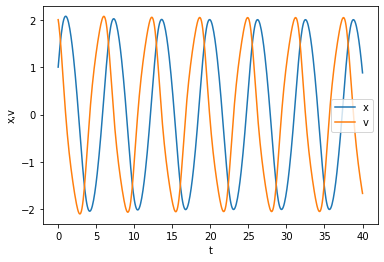

In [16]:
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.xlabel("t")
plt.ylabel("x,v")
plt.legend(["x", "v"]);

You can see that the solution appears oscillatory. Let's be more quantitative than what it *looks* like. An alternative way to visualize this solution is called the phase portrait where we plot the two state variables (x, v) against each other. We include the starting point for visualization.

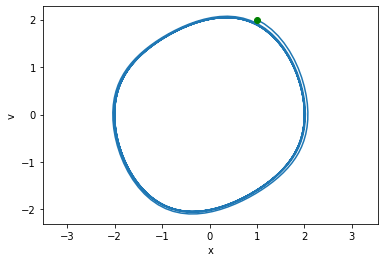

In [17]:
plt.plot(*sol.y)  # unpack the first row into x and second row into the y
# equivalent to plt.plot(sol.y[0], sol.y[1])
plt.plot(*sol.y[:, 0], "go")  # starting point
plt.xlabel("x")
plt.ylabel("v")
plt.axis("equal");

So, evidently it is not exactly periodic in the beginning, but seems to take some time to settle down into a periodic rhythm. That seems to be the case, because if it didn't we would expect to see a continued spiral in or out of this limit cycle. Another way we can assess this quantitatively is to look at the peak positions in our solution. We return to an event type of solution. We seek an event where the derivative $dx/dt=0$, and it is a maximum, which means $x'$ starts positive, becomes zero, and then is negative. Note this is appropriate for this problem, where there is only one, periodic maximum. For other problems, you might need a different approach.

Now, it is important to remember that the event function is only evaluated after a solver point, so we need to make sure the solver points bracket where events occur. This is accomplished by making sure that when we graph the solution from the solver (not from t_eval), that we can visually see where the events will occur.

In [18]:
def max_x_event(t, X):
    Xprime = dXdt(t, X)
    return Xprime[0]  # first derivative, dx/dt = 0


max_x_event.direction = -1  # event must go from positive to negative, i.e. a max

sol = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event)
print(sol.message)
sol.t_events[0]

The solver successfully reached the end of the integration interval.


array([ 0.98712369,  7.29961546, 13.60207133, 19.90194032, 26.2010961 ,
       32.50005162, 38.79895061])

In [19]:
print(sol.y_events[0])

[[ 2.07283325e+00 -6.93889390e-17]
 [ 2.02004874e+00  8.56953397e-16]
 [ 2.00590349e+00  6.93889390e-16]
 [ 2.00196134e+00 -2.96290770e-15]
 [ 2.00085100e+00  2.27595720e-15]
 [ 2.00053732e+00 -5.34294831e-15]
 [ 2.00044864e+00  5.73933262e-15]]


You can see we found seven events. We should plot them on the solution to see that they are in fact maxima. (what could possibly go wrong? if you get the wrong direction, then you will either see minima, or minima and maxima! If your event function is wrong, then it will just be wrong.)  Note we get two rows in our solution, one for x and one for v. From the numbers here, you can see that the x_max values seem to be settling down to about 2.0.

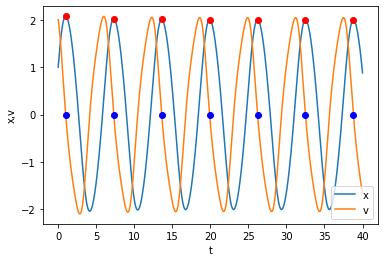

In [20]:
plt.plot(sol.t, sol.y.T)  # full solutions

# break up this calculation for ease of reading
te = sol.t_events[0]
xmax, v_at_xmax = sol.y_events[0].T
plt.plot(te, xmax, "ro")
plt.plot(te, v_at_xmax, "bo")

# compare to. Don't do this, it is confusing and hard to figure out.
# plt.plot(sol.t_events[0], sol.y_events[0][:, 0], 'k*')

plt.xlabel("t")
plt.ylabel("x,v")
plt.legend(["x", "v"]);

That looks good, the red dots appear at the maxima, and they are periodic, so now we can see how x<sub>max</sub> varies with time.

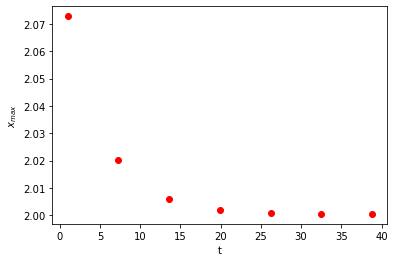

In [21]:
plt.plot(te, xmax, "ro")
plt.xlabel("t")
plt.ylabel("$x_{max}$");

You can see that after about 5 cycles, xmax is practically constant. We can also see that the period (the time between maxima) is converging to a constant. We cannot say much about what happens at longer times. You could integrate longer if it is important to know that. This is a limitation of numerical methods though. To *prove* that it will be constant, you need to do some analytical math that would show the period and x<sub>max</sub> go to a constant.

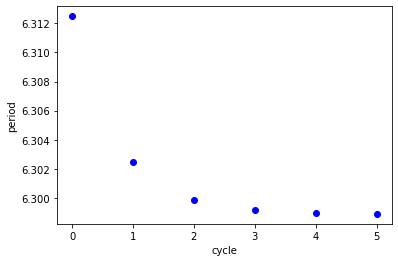

In [22]:
plt.plot(np.diff(te), "bo")
plt.xlabel("cycle")
plt.ylabel("period");

If we seek the steady state, oscillatory behavior of this system, we should discard the solutions in at least the first 4 cycles, since the maxima and periods are still changing.

In [23]:
te[-1], sol.y_events[0][-1]

(38.798950606192165, array([2.00044864e+00, 5.73933262e-15]))

Alternatively, we can use the last point as an initial value for a new integration that should be close to steady state oscillations.

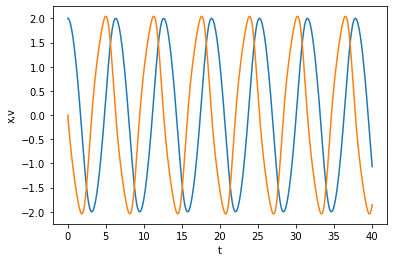

In [24]:
tspan = (0, 40)
X0 = sol.y_events[0][-1]

sol2 = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event)
plt.plot(sol2.t, sol2.y.T)
plt.xlabel("t")
plt.ylabel("x,v");

Here you see about 6 more cycles. The period of these events is practically constant.

In [25]:
sol2.t_events, np.diff(sol2.t_events[0])

([array([2.86945317e-15, 6.29888301e+00, 1.25977615e+01, 1.88966387e+01,
         2.51955156e+01, 3.14943923e+01, 3.77932690e+01])],
 array([6.29888301, 6.2988785 , 6.29887721, 6.29887685, 6.29887676,
        6.29887672]))

And the limit cycle shows practically a single curve.

(-2.2004040548071035,
 2.200489241939398,
 -2.248591036725654,
 2.2485910192056826)

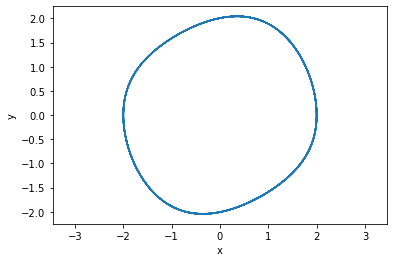

In [26]:
plt.plot(*sol2.y)
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
# makes x-ticks have the same dimension as y-ticks

This limit cycle shows the oscillatory behavior. You can see here that each cycle repeats on top of itself.

**Review** We have been working on finding a steady state oscillatory solution to $\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$, which describes an oscillating system. We examined some ways to tell if a system is oscillating, and to estimate the period of the oscillation.

In [27]:
?solve_ivp

## Summary

We reviewed how to use solve_ivp and common tips/tricks. This includes plotting the results using matplotlib.

In addition to reviewing what we knew from 06-262 on `solve_ivp`, we also talked about how to use **integration events**. These allow us to stop integration at special points. It is very helpful for engineering/design problems.